# Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [68]:
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt


# Get Matplotlib patches for various elliptical confidence regions
def get_ellipse_patch(center, cov, confidence=0.95):
    # Figure out number of stdevs for confidence
    scale = math.sqrt(scipy.stats.chi2.ppf(q=confidence, df=center.shape[0]))
    
    u, s, vh = np.linalg.svd(cov)
    # If det < 0, reflect either u_1 or u_2 to its negative, may as well do u_2
    # For arccos, need y-value of u_1 to be positive
    if u[0,1] < 0:
        u[:,0] = -u[:,0]
    th = np.arccos(np.dot(np.array([1, 0]), u[:,0])) * 180 / np.pi
    return Ellipse((center[0], center[1]), np.sqrt(s[0]) * scale * 2, np.sqrt(s[1])* scale * 2, angle=th, alpha=0.5, color='red')



# Check if the confidence region contains a list of points
# center shape (n,), covariance shape (n,n), points shape (p, n) where p is number of points
# Returns shape (n, 1) boolean
def ellipse_contains_points(center, covariance, points, confidence=0.95):
    u, s, vh = np.linalg.svd(covariance)
    a = u @ np.diag(np.sqrt(s))
    return np.linalg.norm((points - center) @ np.linalg.inv(a).T, axis=1) ** 2 < scipy.stats.chi2.ppf(q=confidence, df=center.shape[0])
    

# Gets patches and containment data for a given fitted GaussianMixture object
# Returns an list of patches, a Numpy array of containment data
def get_patches(gm, confidence, pts):
    patches = []
    contains = []
    for i in range(gm.means_.shape[0]):
        e = get_ellipse_patch(gm.means_[i], gm.covariances_[i], confidence=confidence)
        patches.append(e)
        contains.append(ellipse_contains_points(gm.means_[i], gm.covariances_[i], pts, confidence))

    return patches, np.stack(contains, axis=0)


# Algorithm for determining the number of components according to our winnowing criteria: no overlaps, and each 95% confidence region should contain 10% of all data points
def winnow_gm_components(data, start=10, confidence_limit=0.95):
    for i in range(start, 0, -1):
        gm = GaussianMixture(n_components=i)
        gm.fit(data)
        # If i = 1, then we are done anyway, so break
        if i == 1:
            break

        contains = []
        for j in range(i):
            contains.append(ellipse_contains_points(gm.means_[j], gm.covariances_[j], data, confidence=confidence_limit))
        contains = np.stack(contains)

        # Check if there are any overlaps, if so, continue
        if (contains.sum(axis=0) <= 1).prod().item() != 1:
            continue
        # Check if any ellipses contain less than 10% of data points
        if (contains.sum(axis=1) >= data.shape[0]/10).prod().item() != 1:
            continue
        # Otherwise, we are done
        return gm, i
        
    return gm, i


Generate a single 2d normal distribution

(1000, 2)


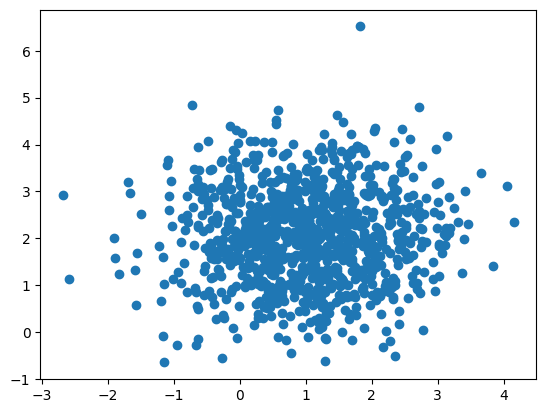

In [69]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[1.02213659 2.07157232]] [[[1.01352512 0.03400048]
  [0.03400048 1.02320831]]]
Num covered: 0.908, valid covered: 0.908, overlapped: 0.0


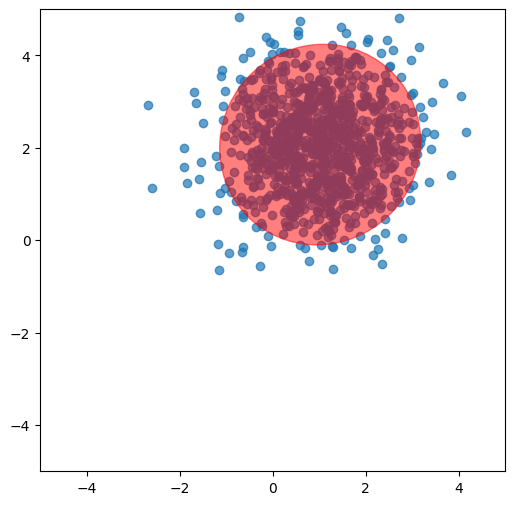

In [71]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [75]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


92
1000
patch way: 0
my way: 954


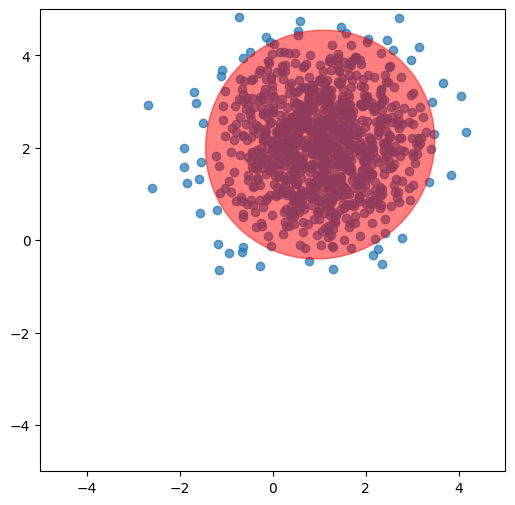

In [73]:
gm, i = winnow_gm_components(data)
i
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


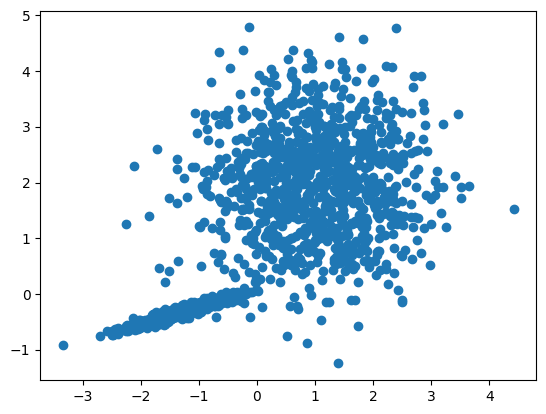

In [53]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[ 0.99451284  1.9692123 ]
 [-1.31591638 -0.32445476]] [[[0.96727164 0.01773218]
  [0.01773218 0.94129743]]

 [[0.25774145 0.0800158 ]
  [0.0800158  0.02774725]]]
Num covered: 0.9573333333333334, valid covered: 0.9573333333333334, overlapped: 0.006666666666666667


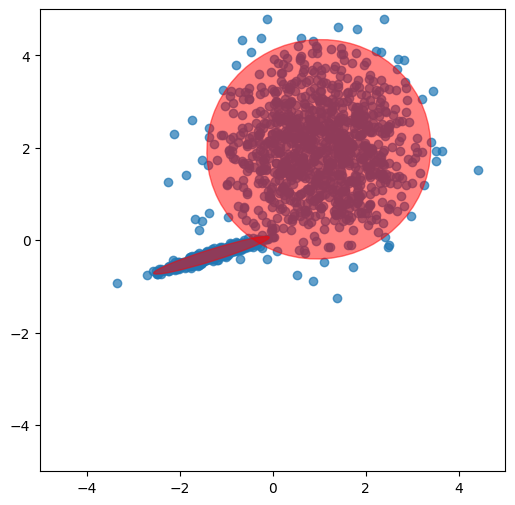

In [54]:

gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()


print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

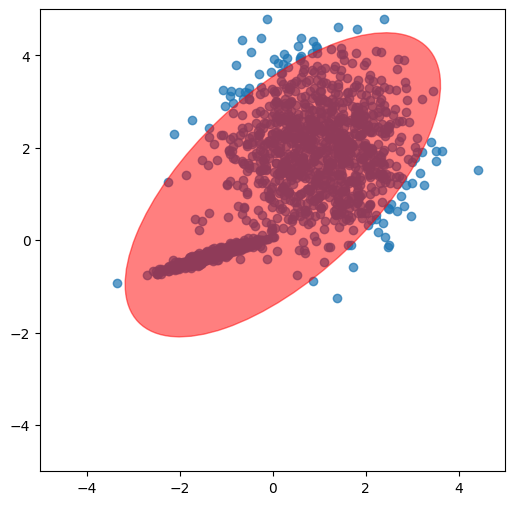

In [55]:
gm, i = winnow_gm_components(data)
i


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


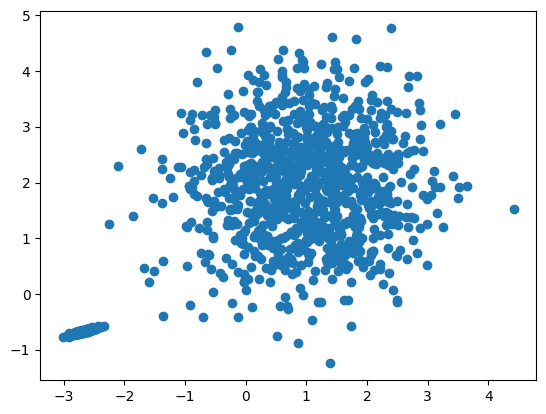

In [56]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



2

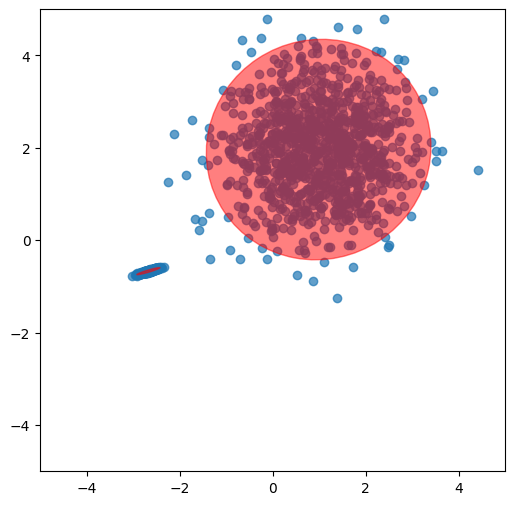

In [57]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)




gm, i = winnow_gm_components(data)
i

# Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


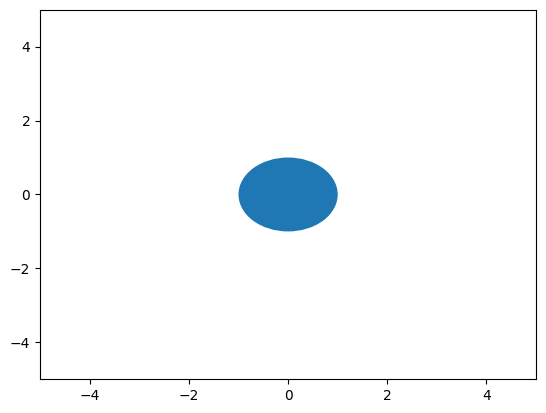

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

# Apply to beat data

## Get measure data

In [59]:
def beat_frames_to_toy(frames, len, target_len):
    x = np.zeros(len + ((target_len - len) % target_len))
    x[frames] = 1
    x = x.reshape((target_len, -1))
    x = x.max(axis=1)
    return x

In [60]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
#from groove.embedding import beat_frames_to_toy
import numpy as np

file = "milaklaw"

raw, proc, sr = get_measures(file, smooth_power)
bf, nf = get_beat_frames(proc, sr, beat_peaks)

In [61]:
frames = np.array([4,4,7,9,11])
beat_frames_to_toy(frames, 12, 6)


array([0., 0., 1., 1., 1., 1.])

In [62]:
out = []
hashable = []
for i in range(len(bf)):
    a = beat_frames_to_toy(bf[i], nf[i], 24)
    out.append(a)
    hashable.append(tuple(a.tolist()))

data = np.stack(out)
data.shape

(179, 24)

In [63]:
import collections
counter = collections.Counter(hashable)

counter.values()
#counter.most_common(5)

dict_values([17, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 14, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 9, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [64]:
beat_frames_to_toy(bf[20], nf[20], 12)

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

[8.26262077 8.01180576]


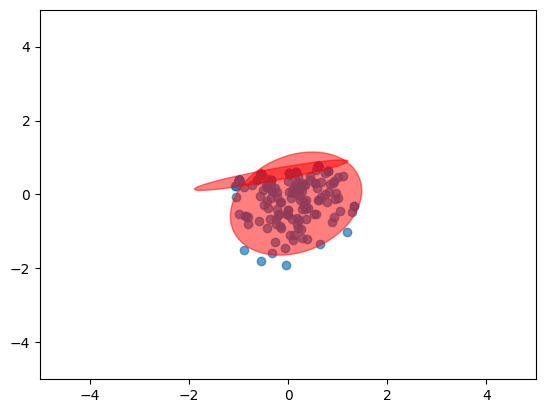

In [65]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gm = GaussianMixture(n_components=2)


pca.fit(data)

print(pca.singular_values_)
red_data = pca.transform(data)

gm.fit(red_data)

patches, coverage = get_patches(gm, 0.95, red_data)

plt.figure()
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])



plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


#gm.fit(data)
#gm.means_.round()

Some rules for choosing the number of components:
1) If there are overlaps between the 95%ile circles, we should reduce.
2) If any circles don't cover 10%, we reduce.

So, start with more, then reduce.

In [66]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm = GaussianMixture(n_components=3)


gm.fit(data)

gm.means_

array([[0.95454545, 0.07575758, 0.03030303, 0.25757576, 0.16666667,
        0.13636364, 0.86363636, 0.04545455, 0.01515152, 1.        ,
        0.24242424, 0.09090909, 0.56060606, 0.09090909, 0.01515152,
        0.86363636, 0.27272727, 0.13636364, 0.81818182, 0.07575758,
        0.06060606, 0.84848485, 0.04545455, 0.        ],
       [0.96348314, 0.08537192, 0.        , 0.17067274, 0.02439198,
        0.04878396, 0.93902005, 0.04878396, 0.02439198, 0.        ,
        0.47564357, 0.1097639 , 0.74388423, 0.06097995, 0.02439198,
        0.81706016, 0.2195278 , 0.08537192, 0.91462808, 0.06097995,
        0.02439198, 0.73175934, 0.09756791, 0.01219599],
       [0.19351199, 0.70954398, 0.032252  , 0.25820402, 0.064504  ,
        0.        , 0.64522801, 0.129008  , 0.064504  , 0.48377998,
        0.35477199, 0.25801599, 0.58072401, 0.19351199, 0.032252  ,
        0.35496002, 0.35477199, 0.        , 0.83874   , 0.22576399,
        0.032252  , 0.64503998, 0.16126   , 0.032252  ]])